Recordatorio : Por favor importar los archivos contenidos en la carpeta en donde se encuentra el notebook.

#Imports

In [38]:
import cv2
import numpy as np
import os

import sys


#utils
import math
import cv2
from PIL import ImageFont, ImageDraw, Image
import time
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from numpy import linalg as LA

Revisión si archivos se cargaron

In [2]:
!(ls ../vibe.mp4 && echo yes) || echo no

ls: cannot access '../vibe.mp4': No such file or directory
no


#Implementación Mask RCNN Shiny

##Obtención de repositorio

Selección de Tensorflow 1.x

In [3]:
%tensorflow_version 1.x



TensorFlow 1.x selected.


Obtención de repositorio

In [4]:
!git clone https://github.com/huuuuusy/Mask-RCNN-Shiny.git

Cloning into 'Mask-RCNN-Shiny'...
remote: Enumerating objects: 82, done.
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 82
Unpacking objects: 100% (82/82), done.


Cambio a directorio del repositorio

In [5]:
import os
os.chdir('Mask-RCNN-Shiny')

In [6]:
from samples import coco
from mrcnn import utils
from mrcnn import model as modellib


Using TensorFlow backend.


## Preparación de modelo


Preparación de data preentrenada (Mask-RCNN entrenada por COCO dataset).

In [7]:
# Load the pre-trained model data
ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


Configuración opcional (GPU)

In [8]:
# Change the config infermation
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    
    # Number of images to train with on each GPU. A 12GB GPU can typically
    # handle 2 images of 1024x1024px.
    # Adjust based on your GPU memory and image sizes. Use the highest
    # number that your GPU can handle for best performance.
    IMAGES_PER_GPU = 1
    
config = InferenceConfig()

In [9]:
# COCO dataset object names
modelSegment = modellib.MaskRCNN(
    mode="inference", model_dir=MODEL_DIR, config=config
)
modelSegment.load_weights(COCO_MODEL_PATH, by_name=True)
class_names = [
    'BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
    'bus', 'train', 'truck', 'boat', 'traffic light',
    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
    'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
    'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
    'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
    'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
    'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
    'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
    'teddy bear', 'hair drier', 'toothbrush'
]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


## Funciones de procesamiento de imagen

**apply_mask** : usada para pasar imagen a escala de grises

**display_instances** : usado para mostrar el resultado de la detección

In [10]:
# This function is used to change the colorful background information to grayscale.
# image[:,:,0] is the Blue channel,image[:,:,1] is the Green channel, image[:,:,2] is the Red channel
# mask == 0 means that this pixel is not belong to the object.
# np.where function means that if the pixel belong to background, change it to gray_image.
# Since the gray_image is 2D, for each pixel in background, we should set 3 channels to the same value to keep the grayscale.

def apply_mask(image, mask):
    height, width, channels = image.shape
    size=(height,width)
    gray_image=np.zeros(size)
    image[:, :, 0] = np.where(
        mask == 0,
        gray_image[:, :],
        image[:, :, 0]
    )
    image[:, :, 1] = np.where(
        mask == 0,
        gray_image[:, :],
        image[:, :, 1]
    )
    image[:, :, 2] = np.where(
        mask == 0,
        gray_image[:, :],
        image[:, :, 2]
    )
    return image

In [12]:
# This function is used to show the object detection result in original image.
def display_instances(image, boxes, masks, ids, names, scores):
    # max_area will save the largest object for all the detection results
    max_area = 0
    
    # n_instances saves the amount of all objects
    n_instances = boxes.shape[0]

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i in range(n_instances):
        if not np.any(boxes[i]):
            continue

        # compute the square of each object
        y1, x1, y2, x2 = boxes[i]
        square = (y2 - y1) * (x2 - x1)

        # use label to select person object from all the 80 classes in COCO dataset
        label = names[ids[i]]
        if label == 'person':
            # save the largest object in the image as main character
            # other people will be regarded as background
            if square > max_area:
                max_area = square
                mask = masks[:, :, i]
            else:
                continue
        else:
            continue
    image = apply_mask(image, mask)
    return image
    #return image

FUNCION PARA APLICAR GRABCUT A LA MÁSCARA OBTENIDA ( Por mejorar . No se tuvieron los resultados esperados)

In [ ]:
def apply_grabcut(image, rcnnMask):
  gcMask = rcnnMask.copy()
  gcMask[gcMask > 0] = cv2.GC_PR_FGD
  gcMask[gcMask == 0] = cv2.GC_BGD
  # allocate memory for two arrays that the GrabCut algorithm
  # internally uses when segmenting the foreground from the
  # background and then apply GrabCut using the mask
  # segmentation method
  #print("[INFO] applying GrabCut to '{}' ROI...".format(
  #  LABELS[classID]))
  fgModel = np.zeros((1, 65), dtype="float64")
  bgModel = np.zeros((1, 65), dtype="float64")
  rect = (50,50,450,290)

  print("image",image.shape)
  print("gcMask", gcMask.shape)
  print("cv2 gcinit", cv2.GC_INIT_WITH_RECT)

  (gcMask, bgModel, fgModel) = cv2.grabCut(image, gcMask,
    rect, bgModel, fgModel, iterCount=5,mode=cv2.GC_INIT_WITH_RECT)
  outputMask = np.where(
    (gcMask == cv2.GC_BGD) | (gcMask == cv2.GC_PR_BGD), 0, 1)
  outputMask = (outputMask * 255).astype("uint8")
  # apply a bitwise AND to the image using our mask generated
  # by GrabCut to generate our final output image
  output = cv2.bitwise_and(image, image, mask=outputMask)
  # show the output GrabCut mask as well as the output of
  # applying the GrabCut mask to the original input image
  imgplot = plt.imshow(outputMask)
  plt.show()
  imgplot2 = plt.imshow(output)
  plt.show()


## Mostrar imagen con máscara ya obtenida



In [40]:
def test_segment(image):
  results = modelSegment.detect([image], verbose=0)
  r = results[0]
  frame = display_instances(
      image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores']
  )
  return frame

#CENTERNET

##Hourglass network

In [14]:
import tensorflow as tf

#KERAS

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.models import Model
from keras.layers import Conv2D, Input, Activation, BatchNormalization, Add, UpSampling2D, ZeroPadding2D
from keras.utils import get_file
import keras.backend as K
import numpy as np

#decode.py
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras import backend as K
from keras.layers import Lambda


In [15]:
"""Hourglass Network for Keras.
# Reference paper
- [Objects as Points]
  (https://arxiv.org/pdf/1904.07850.pdf)
# Reference implementation
- [PyTorch CenterNet]
  (https://github.com/xingyizhou/CenterNet/blob/master/src/lib/models/networks/large_hourglass.py)
- [Keras Stacked_Hourglass_Network_Keras]
  (https://github.com/yuanyuanli85/Stacked_Hourglass_Network_Keras/blob/master/src/net/hourglass.py)
"""



CTDET_COCO_WEIGHTS_PATH = (
  'https://github.com/see--/keras-centernet/'
  'releases/download/0.1.0/ctdet_coco_hg.hdf5')

HPDET_COCO_WEIGHTS_PATH = (
  'https://github.com/see--/keras-centernet/'
  'releases/download/0.1.0/hpdet_coco_hg.hdf5')


def normalize_image(image):
  """Normalize the image for the Hourglass network.
  # Arguments
    image: BGR uint8
  # Returns
    float32 image with the same shape as the input
  """
  mean = [0.40789655, 0.44719303, 0.47026116]
  std = [0.2886383, 0.27408165, 0.27809834]
  return ((np.float32(image) / 255.) - mean) / std


def HourglassNetwork(heads, num_stacks, cnv_dim=256, inres=(512, 512), weights='ctdet_coco',
                     dims=[256, 384, 384, 384, 512]):
  """Instantiates the Hourglass architecture.
  Optionally loads weights pre-trained on COCO.
  Note that the data format convention used by the model is
  the one specified in your Keras config at `~/.keras/keras.json`.
  # Arguments
      num_stacks: number of hourglass modules.
      cnv_dim: number of filters after the resolution is decreased.
      inres: network input shape, should be a multiple of 128.
      weights: one of `None` (random initialization),
            'ctdet_coco' (pre-training on COCO for 2D object detection),
            'hpdet_coco' (pre-training on COCO for human pose detection),
            or the path to the weights file to be loaded.
      dims: numbers of channels in the hourglass blocks.
  # Returns
      A Keras model instance.
  # Raises
      ValueError: in case of invalid argument for `weights`,
          or invalid input shape.
  """
  if not (weights in {'ctdet_coco', 'hpdet_coco', None} or os.path.exists(weights)):
    raise ValueError('The `weights` argument should be either '
                     '`None` (random initialization), `ctdet_coco` '
                     '(pre-trained on COCO), `hpdet_coco` (pre-trained on COCO) '
                     'or the path to the weights file to be loaded.')
  input_layer = Input(shape=(inres[0], inres[1], 3), name='HGInput')
  inter = pre(input_layer, cnv_dim)
  prev_inter = None
  outputs = []
  for i in range(num_stacks):
    prev_inter = inter
    _heads, inter = hourglass_module(heads, inter, cnv_dim, i, dims)
    outputs.extend(_heads)
    if i < num_stacks - 1:
      inter_ = Conv2D(cnv_dim, 1, use_bias=False, name='inter_.%d.0' % i)(prev_inter)
      inter_ = BatchNormalization(epsilon=1e-5, name='inter_.%d.1' % i)(inter_)

      cnv_ = Conv2D(cnv_dim, 1, use_bias=False, name='cnv_.%d.0' % i)(inter)
      cnv_ = BatchNormalization(epsilon=1e-5, name='cnv_.%d.1' % i)(cnv_)

      inter = Add(name='inters.%d.inters.add' % i)([inter_, cnv_])
      inter = Activation('relu', name='inters.%d.inters.relu' % i)(inter)
      inter = residual(inter, cnv_dim, 'inters.%d' % i)

  model = Model(inputs=input_layer, outputs=outputs)
  if weights == 'ctdet_coco':
    weights_path = get_file(
      '%s_hg.hdf5' % weights,
      CTDET_COCO_WEIGHTS_PATH,
      cache_subdir='models',
      file_hash='ce01e92f75b533e3ff8e396c76d55d97ff3ec27e99b1bdac1d7b0d6dcf5d90eb')
    model.load_weights(weights_path)
  elif weights == 'hpdet_coco':
    weights_path = get_file(
      '%s_hg.hdf5' % weights,
      HPDET_COCO_WEIGHTS_PATH,
      cache_subdir='models',
      file_hash='5c562ee22dc383080629dae975f269d62de3a41da6fd0c821085fbee183d555d')
    model.load_weights(weights_path)
  elif weights is not None:
    model.load_weights(weights)

  return model


def hourglass_module(heads, bottom, cnv_dim, hgid, dims):
  # create left features , f1, f2, f4, f8, f16 and f32
  lfs = left_features(bottom, hgid, dims)

  # create right features, connect with left features
  rf1 = right_features(lfs, hgid, dims)
  rf1 = convolution(rf1, 3, cnv_dim, name='cnvs.%d' % hgid)

  # add 1x1 conv with two heads, inter is sent to next stage
  # head_parts is used for intermediate supervision
  heads = create_heads(heads, rf1, hgid)
  return heads, rf1


def convolution(_x, k, out_dim, name, stride=1):
  padding = (k - 1) // 2
  _x = ZeroPadding2D(padding=padding, name=name + '.pad')(_x)
  _x = Conv2D(out_dim, k, strides=stride, use_bias=False, name=name + '.conv')(_x)
  _x = BatchNormalization(epsilon=1e-5, name=name + '.bn')(_x)
  _x = Activation('relu', name=name + '.relu')(_x)
  return _x


def residual(_x, out_dim, name, stride=1):
  shortcut = _x
  num_channels = K.int_shape(shortcut)[-1]
  _x = ZeroPadding2D(padding=1, name=name + '.pad1')(_x)
  _x = Conv2D(out_dim, 3, strides=stride, use_bias=False, name=name + '.conv1')(_x)
  _x = BatchNormalization(epsilon=1e-5, name=name + '.bn1')(_x)
  _x = Activation('relu', name=name + '.relu1')(_x)

  _x = Conv2D(out_dim, 3, padding='same', use_bias=False, name=name + '.conv2')(_x)
  _x = BatchNormalization(epsilon=1e-5, name=name + '.bn2')(_x)

  if num_channels != out_dim or stride != 1:
    shortcut = Conv2D(out_dim, 1, strides=stride, use_bias=False, name=name + '.shortcut.0')(
        shortcut)
    shortcut = BatchNormalization(epsilon=1e-5, name=name + '.shortcut.1')(shortcut)

  _x = Add(name=name + '.add')([_x, shortcut])
  _x = Activation('relu', name=name + '.relu')(_x)
  return _x


def pre(_x, num_channels):
  # front module, input to 1/4 resolution
  _x = convolution(_x, 7, 128, name='pre.0', stride=2)
  _x = residual(_x, num_channels, name='pre.1', stride=2)
  return _x


def left_features(bottom, hgid, dims):
  # create left half blocks for hourglass module
  # f1, f2, f4 , f8, f16, f32 : 1, 1/2, 1/4 1/8, 1/16, 1/32 resolution
  # 5 times reduce/increase: (256, 384, 384, 384, 512)
  features = [bottom]
  for kk, nh in enumerate(dims):
    pow_str = ''
    for _ in range(kk):
      pow_str += '.center'
    _x = residual(features[-1], nh, name='kps.%d%s.down.0' % (hgid, pow_str), stride=2)
    _x = residual(_x, nh, name='kps.%d%s.down.1' % (hgid, pow_str))
    features.append(_x)
  return features


def connect_left_right(left, right, num_channels, num_channels_next, name):
  # left: 2 residual modules
  left = residual(left, num_channels_next, name=name + 'skip.0')
  left = residual(left, num_channels_next, name=name + 'skip.1')

  # up: 2 times residual & nearest neighbour
  out = residual(right, num_channels, name=name + 'out.0')
  out = residual(out, num_channels_next, name=name + 'out.1')
  out = UpSampling2D(name=name + 'out.upsampleNN')(out)
  out = Add(name=name + 'out.add')([left, out])
  return out


def bottleneck_layer(_x, num_channels, hgid):
  # 4 residual blocks with 512 channels in the middle
  pow_str = 'center.' * 5
  _x = residual(_x, num_channels, name='kps.%d.%s0' % (hgid, pow_str))
  _x = residual(_x, num_channels, name='kps.%d.%s1' % (hgid, pow_str))
  _x = residual(_x, num_channels, name='kps.%d.%s2' % (hgid, pow_str))
  _x = residual(_x, num_channels, name='kps.%d.%s3' % (hgid, pow_str))
  return _x


def right_features(leftfeatures, hgid, dims):
  rf = bottleneck_layer(leftfeatures[-1], dims[-1], hgid)
  for kk in reversed(range(len(dims))):
    pow_str = ''
    for _ in range(kk):
      pow_str += 'center.'
    rf = connect_left_right(leftfeatures[kk], rf, dims[kk], dims[max(kk - 1, 0)], name='kps.%d.%s' % (hgid, pow_str))
  return rf


def create_heads(heads, rf1, hgid):
  _heads = []
  for head in sorted(heads):
    num_channels = heads[head]
    _x = Conv2D(256, 3, use_bias=True, padding='same', name=head + '.%d.0.conv' % hgid)(rf1)
    _x = Activation('relu', name=head + '.%d.0.relu' % hgid)(_x)
    _x = Conv2D(num_channels, 1, use_bias=True, name=head + '.%d.1' % hgid)(_x)
    _heads.append(_x)
  return _heads


if __name__ == '__main__':
  kwargs = {
    'num_stacks': 2,
    'cnv_dim': 256,
    'inres': (512, 512),
  }
  heads = {
    'hm': 80,
    'reg': 2,
    'wh': 2
  }
  model = HourglassNetwork(heads=heads, **kwargs)
  print(model.summary(line_length=200))
  # from IPython import embed; embed()


767025152/767024392 [==============================] - 9s 0us/step
Model: "model_1"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                      Output Shape                                Param #                 Connected to                                                      
HGInput (InputLayer)                                              (None, 512, 512, 3)                         0                                                                                         
________________________________________________________________________________________________________________________________________________________________________________________________________
pre.0.pad (ZeroPadding2D)                                         (None, 518, 518, 3)                         0 

In [16]:



def _nms(heat, kernel=3):
  hmax = K.pool2d(heat, (kernel, kernel), padding='same', pool_mode='max')
  keep = K.cast(K.equal(hmax, heat), K.floatx())
  return heat * keep


def _ctdet_decode(hm, reg, wh, k=100, output_stride=4):
  hm = K.sigmoid(hm)
  hm = _nms(hm)
  hm_shape = K.shape(hm)
  reg_shape = K.shape(reg)
  wh_shape = K.shape(wh)
  batch, width, cat = hm_shape[0], hm_shape[2], hm_shape[3]

  hm_flat = K.reshape(hm, (batch, -1))
  reg_flat = K.reshape(reg, (reg_shape[0], -1, reg_shape[-1]))
  wh_flat = K.reshape(wh, (wh_shape[0], -1, wh_shape[-1]))

  def _process_sample(args):
    _hm, _reg, _wh = args
    _scores, _inds = tf.math.top_k(_hm, k=k, sorted=True)
    _classes = K.cast(_inds % cat, 'float32')
    _inds = K.cast(_inds / cat, 'int32')
    _xs = K.cast(_inds % width, 'float32')
    _ys = K.cast(K.cast(_inds / width, 'int32'), 'float32')
    _wh = K.gather(_wh, _inds)
    _reg = K.gather(_reg, _inds)

    _xs = _xs + _reg[..., 0]
    _ys = _ys + _reg[..., 1]

    _x1 = _xs - _wh[..., 0] / 2
    _y1 = _ys - _wh[..., 1] / 2
    _x2 = _xs + _wh[..., 0] / 2
    _y2 = _ys + _wh[..., 1] / 2

    # rescale to image coordinates
    _x1 = output_stride * _x1
    _y1 = output_stride * _y1
    _x2 = output_stride * _x2
    _y2 = output_stride * _y2

    _detection = K.stack([_x1, _y1, _x2, _y2, _scores, _classes], -1)
    return _detection

  detections = K.map_fn(_process_sample, [hm_flat, reg_flat, wh_flat], dtype=K.floatx())
  return detections


def CtDetDecode(model, hm_index=3, reg_index=4, wh_index=5, k=100, output_stride=4):
  def _decode(args):
    hm, reg, wh = args
    return _ctdet_decode(hm, reg, wh, k=k, output_stride=output_stride)
  output = Lambda(_decode)([model.outputs[i] for i in [hm_index, reg_index, wh_index]])
  model = Model(model.input, output)
  return model


def _hpdet_decode(hm, wh, kps, reg, hm_hp, hp_offset, k=100, output_stride=4):
  hm = K.sigmoid(hm)
  hm = _nms(hm)
  hm_shape = K.shape(hm)
  reg_shape = K.shape(reg)
  wh_shape = K.shape(wh)
  kps_shape = K.shape(kps)
  batch, width, cat = hm_shape[0], hm_shape[2], hm_shape[3]

  hm_flat = K.reshape(hm, (batch, -1))
  reg_flat = K.reshape(reg, (reg_shape[0], -1, reg_shape[-1]))
  wh_flat = K.reshape(wh, (wh_shape[0], -1, wh_shape[-1]))
  kps_flat = K.reshape(kps, (kps_shape[0], -1, kps_shape[-1]))

  hm_hp = K.sigmoid(hm_hp)
  hm_hp = _nms(hm_hp)
  hm_hp_shape = K.shape(hm_hp)
  hp_offset_shape = K.shape(hp_offset)

  hm_hp_flat = K.reshape(hm_hp, (hm_hp_shape[0], -1, hm_hp_shape[-1]))
  hp_offset_flat = K.reshape(hp_offset, (hp_offset_shape[0], -1, hp_offset_shape[-1]))

  def _process_sample(args):
    _hm, _reg, _wh, _kps, _hm_hp, _hp_offset = args
    _scores, _inds = tf.math.top_k(_hm, k=k, sorted=True)
    _classes = K.cast(_inds % cat, 'float32')
    _inds = K.cast(_inds / cat, 'int32')
    _xs = K.cast(_inds % width, 'float32')
    _ys = K.cast(K.cast(_inds / width, 'int32'), 'float32')
    _wh = K.gather(_wh, _inds)
    _reg = K.gather(_reg, _inds)
    _kps = K.gather(_kps, _inds)

    # shift keypoints by their center
    _kps_x = _kps[:, ::2]
    _kps_y = _kps[:, 1::2]
    _kps_x = _kps_x + K.expand_dims(_xs, -1)  # k x J
    _kps_y = _kps_y + K.expand_dims(_ys, -1)  # k x J
    _kps = K.stack([_kps_x, _kps_y], -1)  # k x J x 2

    _xs = _xs + _reg[..., 0]
    _ys = _ys + _reg[..., 1]

    _x1 = _xs - _wh[..., 0] / 2
    _y1 = _ys - _wh[..., 1] / 2
    _x2 = _xs + _wh[..., 0] / 2
    _y2 = _ys + _wh[..., 1] / 2

    # snap center keypoints to the closest heatmap keypoint
    def _process_channel(args):
      __kps, __hm_hp = args
      thresh = 0.1
      __hm_scores, __hm_inds = tf.math.top_k(__hm_hp, k=k, sorted=True)
      __hm_xs = K.cast(__hm_inds % width, 'float32')
      __hm_ys = K.cast(K.cast(__hm_inds / width, 'int32'), 'float32')
      __hp_offset = K.gather(_hp_offset, __hm_inds)
      __hm_xs = __hm_xs + __hp_offset[..., 0]
      __hm_ys = __hm_ys + __hp_offset[..., 1]
      mask = K.cast(__hm_scores > thresh, 'float32')
      __hm_scores = (1. - mask) * -1. + mask * __hm_scores
      __hm_xs = (1. - mask) * -10000. + mask * __hm_xs
      __hm_ys = (1. - mask) * -10000. + mask * __hm_ys
      __hm_kps = K.stack([__hm_xs, __hm_ys], -1)  # k x 2
      __broadcast_hm_kps = K.expand_dims(__hm_kps, 1)  # k x 1 x 2
      __broadcast_kps = K.expand_dims(__kps, 0)  # 1 x k x 2
      dist = K.sqrt(K.sum(K.pow(__broadcast_kps - __broadcast_hm_kps, 2), 2))  # k, k
      min_dist = K.min(dist, 0)
      min_ind = K.argmin(dist, 0)
      __hm_scores = K.gather(__hm_scores, min_ind)
      __hm_kps = K.gather(__hm_kps, min_ind)
      mask = (K.cast(__hm_kps[..., 0] < _x1, 'float32') + K.cast(__hm_kps[..., 0] > _x2, 'float32') +
              K.cast(__hm_kps[..., 1] < _y1, 'float32') + K.cast(__hm_kps[..., 1] > _y2, 'float32') +
              K.cast(__hm_scores < thresh, 'float32') +
              K.cast(min_dist > 0.3 * (K.maximum(_wh[..., 0], _wh[..., 1])), 'float32'))
      mask = K.expand_dims(mask, -1)
      mask = K.cast(mask > 0, 'float32')
      __kps = (1. - mask) * __hm_kps + mask * __kps
      return __kps

    _kps = K.permute_dimensions(_kps, (1, 0, 2))  # J x k x 2
    _hm_hp = K.permute_dimensions(_hm_hp, (1, 0))  # J x -1
    _kps = K.map_fn(_process_channel, [_kps, _hm_hp], dtype='float32')
    _kps = K.reshape(K.permute_dimensions(_kps, (1, 2, 0)), (k, -1))  # k x J * 2

    # rescale to image coordinates
    _x1 = output_stride * _x1
    _y1 = output_stride * _y1
    _x2 = output_stride * _x2
    _y2 = output_stride * _y2
    _kps = output_stride * _kps

    _boxes = K.stack([_x1, _y1, _x2, _y2], -1)
    _scores = K.expand_dims(_scores, -1)
    _classes = K.expand_dims(_classes, -1)
    _detection = K.concatenate([_boxes, _scores, _kps, _classes], -1)
    return _detection

  detections = K.map_fn(_process_sample,
                        [hm_flat, reg_flat, wh_flat, kps_flat, hm_hp_flat, hp_offset_flat], dtype='float32')
  return detections


def HpDetDecode(model, hm_index=6, wh_index=11, kps_index=9, reg_index=10, hm_hp_index=7, hp_offset_index=8,
                k=100, output_stride=4):
  def _decode(args):
    hm, wh, kps, reg, hm_hp, hp_offset = args
    return _hpdet_decode(hm, wh, kps, reg, hm_hp, hp_offset, k=k, output_stride=output_stride)

  output = Lambda(_decode)(
    [model.outputs[i] for i in [hm_index, wh_index, kps_index, reg_index, hm_hp_index, hp_offset_index]])
  model = Model(model.input, output)
  return model


##COCO DRAWER + funciones de CV para mostrar output (dibujar pose, anchor box ,etc)

```
# Tiene formato de código
```



In [17]:


coco_names = ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush',]  # noqa


def get_color(c, x, max_value, colors=[[1, 0, 1], [0, 0, 1], [0, 1, 1], [0, 1, 0], [1, 1, 0], [1, 0, 0]]):
  # https://github.com/pjreddie/darknet/blob/master/src/image.c
  ratio = (x / max_value) * 5
  i = math.floor(ratio)
  j = math.ceil(ratio)
  ratio -= i
  r = (1. - ratio) * colors[i][c] + ratio * colors[j][c]
  return r


def get_rgb_color(cls, clses):
  offset = cls * 123457 % clses
  red = get_color(2, offset, clses)
  green = get_color(1, offset, clses)
  blue = get_color(0, offset, clses)
  return int(red * 255), int(green * 255), int(blue * 255)


class COCODrawer:
  def __init__(self, font_size=24, font="../Roboto-Regular.ttf", char_width=14):
    self.coco_names = coco_names
    self.font_size = font_size
    self.font = ImageFont.truetype(font, font_size)
    self.char_width = char_width

    self.num_joints = 17
    self.edges = [[0, 1], [0, 2], [1, 3], [2, 4],
                  [3, 5], [4, 6], [5, 6],
                  [5, 7], [7, 9], [6, 8], [8, 10],
                  [5, 11], [6, 12], [11, 12],
                  [11, 13], [13, 15], [12, 14], [14, 16]]
    self.ec = [(255, 0, 0), (0, 0, 255), (255, 0, 0), (0, 0, 255),
               (255, 0, 0), (0, 0, 255), (255, 0, 255),
               (255, 0, 0), (255, 0, 0), (0, 0, 255), (0, 0, 255),
               (255, 0, 0), (0, 0, 255), (255, 0, 255),
               (255, 0, 0), (255, 0, 0), (0, 0, 255), (0, 0, 255)]
    self.colors_hp = [(255, 0, 255), (255, 0, 0), (0, 0, 255),
                      (255, 0, 0), (0, 0, 255), (255, 0, 0), (0, 0, 255),
                      (255, 0, 0), (0, 0, 255), (255, 0, 0), (0, 0, 255),
                      (255, 0, 0), (0, 0, 255), (255, 0, 0), (0, 0, 255),
                      (255, 0, 0), (0, 0, 255)]

  def draw_pose(self, img, kps):
    """Draw the pose like https://github.com/xingyizhou/CenterNet/blob/master/src/lib/utils/debugger.py#L191
    Arguments
      img: uint8 BGR
      kps: (17, 2) keypoint [[x, y]] coordinates
    """
    kps = np.array(kps, dtype=np.int32).reshape(self.num_joints, 2)
    TEXT_FACE = cv2.FONT_HERSHEY_DUPLEX
    TEXT_SCALE = 1
    TEXT_THICKNESS = 1
    i = 1

    for j in range(self.num_joints):
      cv2.circle(img, (kps[j, 0], kps[j, 1]), 3, self.colors_hp[j], -1)
      TEXT = str(i)
      text_size, _ = cv2.getTextSize(TEXT, TEXT_FACE, TEXT_SCALE, TEXT_THICKNESS)
      text_origin = (int(kps[j, 0] - text_size[0] / 2),  int(kps[j, 1] + text_size[1] / 2))
      cv2.putText(img, TEXT, text_origin, TEXT_FACE, TEXT_SCALE, (127,255,127), TEXT_THICKNESS, cv2.LINE_AA)
      i+=1
  
    for j, e in enumerate(self.edges):
      if kps[e].min() > 0:
        cv2.line(img, (kps[e[0], 0], kps[e[0], 1]), (kps[e[1], 0], kps[e[1], 1]), self.ec[j], 2,
                 lineType=cv2.LINE_AA)
    return img

  def draw_box(self, img, x1, y1, x2, y2, cl):
    cl = int(cl)
    x1, y1, x2, y2 = int(round(float(x1))), int(round(float(y1))), int(round(float(x2))), int(round(float(y2)))
    h = img.shape[0]
    width = max(1, int(h * 0.006))
    name = self.coco_names[cl].split()[-1]
    bgr_color = get_rgb_color(cl, len(self.coco_names))[::-1]
    # bounding box
    cv2.rectangle(img, (x1, y1), (x2, y2), bgr_color, width)
    # font background
    font_width = len(name) * self.char_width
    cv2.rectangle(img, (x1 - math.ceil(width / 2), y1 - self.font_size), (x1 + font_width, y1), bgr_color, -1)
    # text
    pil_img = Image.fromarray(img[..., ::-1])
    draw = ImageDraw.Draw(pil_img)
    draw.text((x1 + width, y1 - self.font_size), name, font=self.font, fill=(0, 0, 0, 255))
    img = np.array(pil_img)[..., ::-1].copy()
    return img


In [18]:
##Letterbox
def affine_transform_coords(coords, M):
  A, B = M[:2, :2], M[:2, 2:3]
  transformed_coords = A @ coords + B
  return transformed_coords


def training_transform(height, width, output_height, output_width):
  # https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/warp_affine/warp_affine.html
  height_scale, width_scale = output_height / height, output_width / width
  scale = min(height_scale, width_scale)
  resize_height, resize_width = round(height * scale), round(width * scale)
  pad_top = (output_height - resize_height) // 2
  pad_left = (output_width - resize_width) // 2
  A = np.float32([[scale, 0.0], [0.0, scale]])
  B = np.float32([[pad_left], [pad_top]])
  M = np.hstack([A, B])
  return M, output_height, output_width

def invert_transform(M):
  # T = A @ x + B => x = A_inv @ (T - B) = A_inv @ T + (-A_inv @ B)
  A_inv = np.float32([[1. / M[0, 0], 0.0], [0.0, 1. / M[1, 1]]])
  B_inv = -A_inv @ M[:, 2:3]
  M_inv = np.hstack([A_inv, B_inv])
  return M_inv


class LetterboxTransformer:
  def __init__(self, height=None, width=None, mode='training', max_stride=128):
    """Resize the input images. For `mode='training'` the resolution is fixed to `height` x `width`.
       The resolution is changed but the aspect ratio is kept.
       In `mode='testing'` the input is padded to the next bigger multiple of `max_stride` of the network.
       The orginal resolutions is thus kept."""
    self.height = height
    self.width = width
    self.mode = mode
    self.max_stride = max_stride
    self.M = None
    self.M_inv = None

  def __call__(self, image):
    h, w = image.shape[:2]
    if self.mode == 'training':
      M, h_out, w_out = training_transform(h, w, self.height, self.width)
    elif self.mode == 'testing':
      M, h_out, w_out = testing_transform(h, w, self.max_stride)

    # https://answers.opencv.org/question/33516/cv2warpaffine-results-in-an-image-shifted-by-05-pixel
    # This is different from `cv2.resize(image, (resize_width, resize_height))` & pad
    letterbox = cv2.warpAffine(image, M, (w_out, h_out))
    self.M = M
    self.M_inv = invert_transform(M)
    return letterbox

  def correct_box(self, x1, y1, x2, y2):
    coords = np.float32([[x1, x2], [y1, y2]])
    coords = affine_transform_coords(coords, self.M_inv)
    x1, y1, x2, y2 = coords[0, 0], coords[1, 0], coords[0, 1], coords[1, 1]
    return x1, y1, x2, y2

  def correct_coords(self, coords):
    coords = affine_transform_coords(coords, self.M_inv)
    return coords


##Inicializar modelo

In [19]:
output= './output'
os.makedirs(output, exist_ok=True)
kwargs = {
  'num_stacks': 2,
  'cnv_dim': 256,
  'weights': 'hpdet_coco',
  'inres': (512,512), #args.inres
}
heads = {
  'hm': 1,  # 6
  'hm_hp': 17,  # 7
  'hp_offset': 2,  # 8
  'hps': 34,  # 9
  'reg': 2,  # 10
  'wh': 2,  # 11
}

In [20]:
model = HourglassNetwork(heads=heads, **kwargs)
model = HpDetDecode(model)
drawer = COCODrawer()
letterbox_transformer = LetterboxTransformer(512, 512) #argres 0 1


781172736/781170696 [==============================] - 13s 0us/step


##Métodos de estimación de ángulos por articulación

In [21]:
def obtener_info_articulaciones(lista_coord):
    df_temp = df.copy()
    for index, row in df_temp.iterrows():
        val_a = lista_coord[int(row['a']) - 1]
        val_b = lista_coord[int(row['b']) - 1]
        val_c = lista_coord[int(row['c']) - 1]
        df_temp.loc[index, 'angulo'] = f'{calcular_angulo([val_a,val_b,val_c]):.2f}'
    print(df_temp)

In [23]:

def calcular_angulo(lista_coord):
  lista_coord = [np.array(cord) for cord in lista_coord]
  val_a = lista_coord[0] - lista_coord[1]
  val_b = lista_coord[2] - lista_coord[1]
  a_dot_b = np.dot(val_a,val_b)
  norm_product = LA.norm(val_a) * LA.norm(val_b)
  partial_result = a_dot_b / norm_product
  return  np.degrees(np.arccos(partial_result))


##Inicializar csv de información de articulaciones

In [24]:
df = pd.read_csv('../output.csv',delimiter=";")

In [25]:
df.head()

,Tipo,a,b,c,Lado
0,Pierna,13,15,17,Derecha
1,Pierna,12,14,16,Izquierda
2,Brazo,6,8,10,Izquierda
3,Brazo,7,9,11,Derecha
4,Cintura,7,9,13,Derecha


##Inicializar videos de prueba

In [26]:

video = '../test2_cam1_11.mp4'
cap = cv2.VideoCapture(video)
out_fn = os.path.join(output, 'hpdet.' + os.path.basename(video))
fourcc = cv2.VideoWriter_fourcc('F', 'M', 'P', '4')

fps = 10
frameSize =(512,512)
out = cv2.VideoWriter(out_fn, fourcc=fourcc, fps=fps, frameSize=(int(cap.get(3)), int(cap.get(4))),isColor=True)
tic = time.time()

##Método que detecta estimación de pose

In [27]:
def get_pose_estimation(img):
  pimg = letterbox_transformer(img)
  pimg = normalize_image(pimg)
  pimg = np.expand_dims(pimg, 0)
  detections = model.predict(pimg)[0]
  list_detections = list()
  for d in detections:
    score, cl = d[4], d[-1]
    if score < 0.3:
      break
    x1, y1, x2, y2 = d[:4]
    kps = d[5:-1]
    kps_x = kps[:17]
    kps_y = kps[17:]
    kps = letterbox_transformer.correct_coords(np.vstack([kps_x, kps_y])).T
    x1, y1, x2, y2 = letterbox_transformer.correct_box(x1, y1, x2, y2)
    img = drawer.draw_pose(img, kps)
    img = drawer.draw_box(img, x1, y1, x2, y2, cl)
    list_detections.append({'kps' : kps, 'img' : img})
  return list_detections



##Obteniendo estimación de pose para frame en específico

In [32]:
#PROBANDO OBTENIEDON FRAMES ESPECIFICOS
def get_pose_estimation_by_frame(cap,frame_number):
  # Get the total numer of frames in the video.
  frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
  cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number - 1) # ya que empieza desde cero
  success, img = cap.read() 
  list_detections = get_pose_estimation(img)
  for det in list_detections:
        imgplot = plt.imshow(img)
        plt.show()



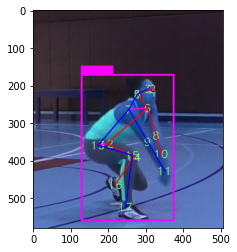

In [33]:
get_pose_estimation_by_frame(cap,46)

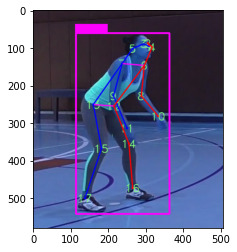

In [34]:
get_pose_estimation_by_frame(cap,5)

##Obteniendo estimación de pose indicando el número de frames a extraer / lista de frames como input

In [44]:
def get_pose_estimation_by_number_of_frames(cap, frame_list_size,frame_list = None):
# Get the total numer of frames in the video.
  frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
  if not frame_list:
    frame_list = np.arange(0,(frame_count + frame_count /(frame_list_size - 1)),(frame_count/(frame_list_size -1))).tolist()
    frame_list = [int(x) if x != frame_count else x - 1 for x in frame_list]
    print(frame_list)
  for frame_number in frame_list:
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number) # optional
    success, img = cap.read()  
    if img is not None:
      result_estimation = get_pose_estimation(img)
      if len(result_estimation) == 1:
        #img
        img = result_estimation[0]['img']
        obtener_info_articulaciones(result_estimation[0]['kps'])
        imgplot = plt.imshow(img)
        plt.show()
   


129.0
[0, 43, 86, 128.0]
      Tipo   a   b   c       Lado  angulo
0   Pierna  13  15  17    Derecha  150.62
1   Pierna  12  14  16  Izquierda  162.13
2    Brazo   6   8  10  Izquierda  135.88
3    Brazo   7   9  11    Derecha  146.01
4  Cintura   7   9  13    Derecha  121.91
5  Cintura   6  12  10  Izquierda   71.21


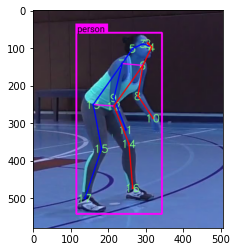

      Tipo   a   b   c       Lado  angulo
0   Pierna  13  15  17    Derecha  111.34
1   Pierna  12  14  16  Izquierda   85.72
2    Brazo   6   8  10  Izquierda  173.89
3    Brazo   7   9  11    Derecha  178.98
4  Cintura   7   9  13    Derecha   68.00
5  Cintura   6  12  10  Izquierda   85.61


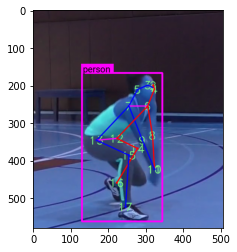

      Tipo   a   b   c       Lado  angulo
0   Pierna  13  15  17    Derecha  153.74
1   Pierna  12  14  16  Izquierda  109.95
2    Brazo   6   8  10  Izquierda   95.60
3    Brazo   7   9  11    Derecha   92.25
4  Cintura   7   9  13    Derecha  156.60
5  Cintura   6  12  10  Izquierda   38.24


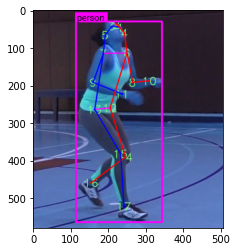

      Tipo   a   b   c       Lado  angulo
0   Pierna  13  15  17    Derecha  136.07
1   Pierna  12  14  16  Izquierda  166.00
2    Brazo   6   8  10  Izquierda  106.83
3    Brazo   7   9  11    Derecha  103.53
4  Cintura   7   9  13    Derecha  173.32
5  Cintura   6  12  10  Izquierda   15.07


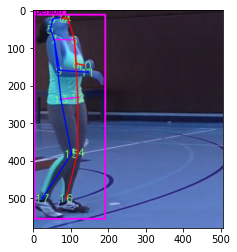

In [39]:
get_pose_estimation_by_number_of_frames(cap=cap,frame_list_size=4)


129.0
      Tipo   a   b   c       Lado  angulo
0   Pierna  13  15  17    Derecha  157.82
1   Pierna  12  14  16  Izquierda  163.43
2    Brazo   6   8  10  Izquierda  136.49
3    Brazo   7   9  11    Derecha  133.98
4  Cintura   7   9  13    Derecha  118.27
5  Cintura   6  12  10  Izquierda   62.25
None


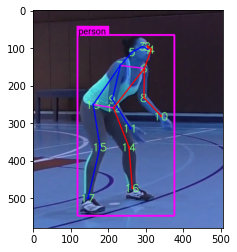

      Tipo   a   b   c       Lado  angulo
0   Pierna  13  15  17    Derecha  130.22
1   Pierna  12  14  16  Izquierda  121.52
2    Brazo   6   8  10  Izquierda  171.50
3    Brazo   7   9  11    Derecha  156.49
4  Cintura   7   9  13    Derecha  107.78
5  Cintura   6  12  10  Izquierda   89.26
None


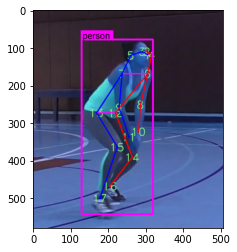

      Tipo   a   b   c       Lado  angulo
0   Pierna  13  15  17    Derecha   88.99
1   Pierna  12  14  16  Izquierda   49.52
2    Brazo   6   8  10  Izquierda  178.24
3    Brazo   7   9  11    Derecha  175.86
4  Cintura   7   9  13    Derecha   47.54
5  Cintura   6  12  10  Izquierda   42.40
None


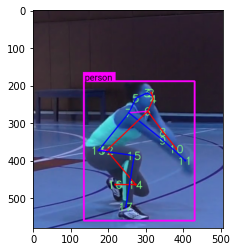

      Tipo   a   b   c       Lado  angulo
0   Pierna  13  15  17    Derecha   61.91
1   Pierna  12  14  16  Izquierda   47.64
2    Brazo   6   8  10  Izquierda  167.92
3    Brazo   7   9  11    Derecha  172.09
4  Cintura   7   9  13    Derecha   41.65
5  Cintura   6  12  10  Izquierda   40.83
None


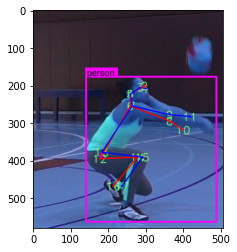

      Tipo   a   b   c       Lado  angulo
0   Pierna  13  15  17    Derecha   85.44
1   Pierna  12  14  16  Izquierda   58.10
2    Brazo   6   8  10  Izquierda  177.73
3    Brazo   7   9  11    Derecha  172.97
4  Cintura   7   9  13    Derecha   46.70
5  Cintura   6  12  10  Izquierda   31.45
None


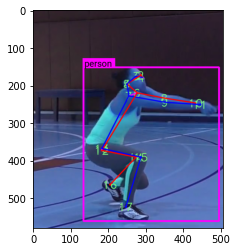

      Tipo   a   b   c       Lado  angulo
0   Pierna  13  15  17    Derecha  137.56
1   Pierna  12  14  16  Izquierda  122.27
2    Brazo   6   8  10  Izquierda  108.46
3    Brazo   7   9  11    Derecha  101.78
4  Cintura   7   9  13    Derecha  121.77
5  Cintura   6  12  10  Izquierda   36.71
None


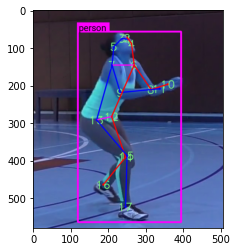

In [ ]:

get_pose_estimation_by_number_of_frames(cap=cap,frame_list_size=None, frame_list=[11,	32	,49,	58,	64,	79])

##Extrayendo estimación de poses por cada frame de video

In [ ]:
def get_pose_estimation_for_all_video(cap):
    k = 0
    while cap.isOpened():
      if k > 10000:
        print("Bye")
        break
      if k > 0 and k % 100 == 0:
        toc = time.time()
        duration = toc - tic
        print("[%05d]: %.3f seconds / 100 iterations" % (k, duration))
        tic = toc

      k += 1
      ret, img = cap.read()
      if not ret:
        print("Done")
        break
      get_pose_estimation(img) 
    print("Video saved to: %s" % out_fn)
    cap.release()
    out.release()
    cv2.destroyAllWindows()


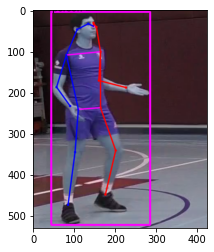

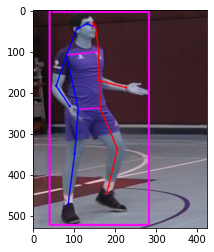

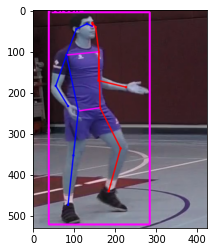

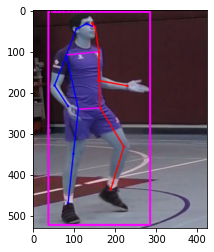

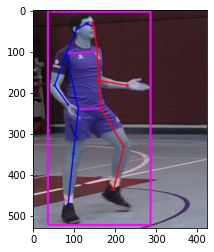

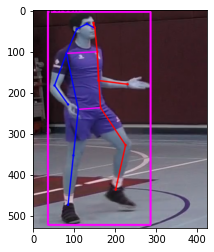

KeyboardInterrupt: ignored

In [ ]:
#get_pose_estimation_for_all_video(cap)

##Estimación de Pose con Segmentación (Implementación de Mask RCNN Shiny)

> Bloque con sangría







In [46]:
def get_pose_estimation_segmentation_by_number_of_frames(cap, frame_list_size,frame_list = None):
# Get the total numer of frames in the video.
  frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
  if not frame_list:
    frame_list = np.arange(0,(frame_count + frame_count /(frame_list_size - 1)),(frame_count/(frame_list_size -1))).tolist()
    frame_list = [int(x) if x != frame_count else x - 1 for x in frame_list]
  for frame_number in frame_list:
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number) # optional
    success, img = cap.read()  
    if img is not None:
      img = test_segment(img)
      result_estimation = get_pose_estimation(img)
      if len(result_estimation) == 1:
        #img
        img = result_estimation[0]['img']
        obtener_info_articulaciones(result_estimation[0]['kps'])
        imgplot = plt.imshow(img)
        plt.show()
   


      Tipo   a   b   c       Lado  angulo
0   Pierna  13  15  17    Derecha  156.02
1   Pierna  12  14  16  Izquierda  158.36
2    Brazo   6   8  10  Izquierda  157.69
3    Brazo   7   9  11    Derecha  128.10
4  Cintura   7   9  13    Derecha  118.54
5  Cintura   6  12  10  Izquierda   67.79


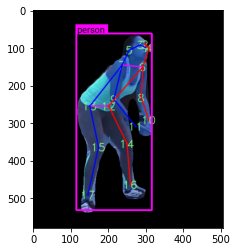

In [47]:
get_pose_estimation_segmentation_by_number_of_frames(cap,frame_list=[20], frame_list_size=None)

      Tipo   a   b   c       Lado  angulo
0   Pierna  13  15  17    Derecha  154.01
1   Pierna  12  14  16  Izquierda  160.76
2    Brazo   6   8  10  Izquierda  156.52
3    Brazo   7   9  11    Derecha  128.44
4  Cintura   7   9  13    Derecha  116.96
5  Cintura   6  12  10  Izquierda   68.31


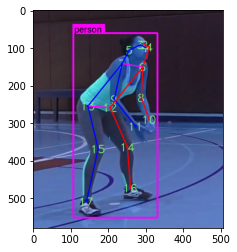

In [48]:
get_pose_estimation_by_number_of_frames(cap,frame_list=[20], frame_list_size=None)